---
>Disclaimer:  
>I did not paid and do not own any of the this.  
>All of the material were found on youtube or in other Github projects - including the code solutions.
>
>Youtube resources:
>- C1W3L01 - C1W3L11 - https://www.youtube.com/watch?v=fXOsFF95ifk&list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0&index=25
>- Lecture 2 - Deep Learning Intuition - https://www.youtube.com/watch?v=AwQHqWyHRpU&list=PLoROMvodv4rOABXSygHTsbvUz4G_YQhOb&index=2
>- 3b1b AI series - https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi
>
>Github project resources:
>- https://github.com/Kulbear/deep-learning-coursera (main notebook + solutions)
>- https://github.com/andersy005/deep-learning-specialization-coursera (datasets, util scripts)
>
>What I did:
>Learnt about this subject by re-implementing the solutions in another language (Rust - https://github.com/google/evcxr/tree/master/evcxr_jupyter).  
>Some aspects of the solutions are different (longer, slower) because this is an opportunity (for me) to better understand the concepts.  
>For this reason, sometimes I changed terms, names or relations from the original text in order to better correspond to my acutual re-implementation.  
>(To sum it up, this is "exploratory exercise", not "serious implementation")

---

# Planar data classification with one hidden layer

Welcome to your week 3 programming assignment. It's time to build your first neural network, which will have a hidden layer. You will see a big difference between this model and the one you implemented using logistic regression. 

**You will learn how to:**
- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh 
- Compute the cross entropy loss 
- Implement forward and backward propagation


## 0 - Optimization ##

Use :help for seeing commands from evcxr.
Before any code is executed, use :opt to set the optimization level (until it's set to 2 = speed)

In [2]:
:opt
:opt

Optimization: 0

Optimization: 2

## 1 - Packages ##

First, let's run the cell below to import all the packages that you will need during this assignment. 

In [3]:
// Cargo.toml - fine configuration of depedencies (and their versions)
// https://github.com/google/evcxr (version = "0.3.3" )

:dep base64 = "0.10.1"

// # pacman -S hdf5 
:dep hdf5 = "0.5.1"
// n-dimensional arrays, with serde (de/serialization) and rayon (parallelization) support
:dep ndarray = { version = "0.12", features = ["serde-1"] }
// https://docs.rs/ndarray/0.12.1/ndarray/doc/ndarray_for_numpy_users/index.html
// https://docs.rs/ndarray/0.12.1/ndarray/struct.ArrayBase.html

// image manipulation and display
:dep image = "0.20.1"
:dep evcxr_image = "1.0.0"
// evcxr_image depends on image ^0.20.0

// has useful numeric traits such as "has a One value", "has a Zero value", etc
:dep num-traits = "0.2.6"

:dep rand = "0.6.5"

// # pacman -S gnuplot
:dep gnuplot = "0.0.31"

:dep tempfile = "3.0.7"

"done" // this takes ~ 5 minutes to compile

"done"

In [6]:
// external and scoped libs
extern crate base64;
extern crate hdf5;
extern crate ndarray;
extern crate image;
extern crate evcxr_image;
extern crate num_traits;
extern crate rand;
extern crate gnuplot;
extern crate tempfile;
//
use ndarray::prelude::*;
// <image::RgbImage>::evcxr_display() for image displaying
use evcxr_image::ImageDisplay;
"done"

"done"

---

## 2 - Dataset ##

First, let's get the dataset you will work on. The following code will load a "flower" 2-class dataset into variables `X` and `Y`.

In [14]:
pub fn load_planar_dataset() -> (Array2<f32>, Array2<f32>) {
    let examples = 400;
    let class_variants = 2;
    let class_points = examples / class_variants;

    let mut rng = {
        use rand::{rngs::SmallRng, SeedableRng};
        SmallRng::seed_from_u64(1)
    };

    // for x, each row is a single example
    // for y, each row is a label (0 for red, 1 for blue)

    let (x, y) = (0..class_variants)
        .map(|j| {
            // each interaction create a new pair of (xi, yi),
            // where each is a Array2 of class_points rows
            // (and xi has 2 cols, whereas yi only has 1)

            use rand::{distributions::StandardNormal, Rng};

            let j2 = j + 1;
            let t = Array::linspace(j as f32 * 3.12, j2 as f32 * 3.12, class_points)
                + Array1::from_shape_fn(class_points, |_| {
                    rng.sample(StandardNormal) as f32 * 0.2
                });
            // assert_eq!((class_points,), t.dim());

            let max_ray = 4.0;
            let radius = max_ray * t.mapv(|ti| f32::sin(4.0 * ti))
                + Array1::from_shape_fn(class_points, |_| {
                    rng.sample(StandardNormal) as f32 * 0.2
                });

            let xi = ndarray::stack(
                Axis(0),
                &[
                    (&radius * &t.mapv(f32::sin))
                        .insert_axis(Axis(0)) // row vector
                        .view(),
                    (&radius * &t.mapv(f32::cos))
                        .insert_axis(Axis(0)) // row vector
                        .view(),
                ],
            )
            .unwrap();
            let yi = Array2::from_elem((1, class_points), j as f32);

            assert_eq!((2, class_points), xi.dim());
            assert_eq!((1, class_points), yi.dim());
            (xi, yi)
        })
        .fold(
            (None, None), // initialization
            |(x_acc, y_acc): (Option<Array2<f32>>, Option<Array2<f32>>), (xi, yi)| {
                let x_acc = stack_or_clone(x_acc, xi).unwrap();
                let y_acc = stack_or_clone(y_acc, yi).unwrap();
                (Some(x_acc), Some(y_acc))
            },
        );
    let (x, y) = (x.unwrap().t().to_owned(), y.unwrap().t().to_owned());
    assert_eq!((examples, 2), x.dim());
    assert_eq!((examples, 1), y.dim());
    (x, y)
}

// given two arrays, stacks them together into a new array
// if the first one doesn't exists, just copies the other one
pub fn stack_or_clone<T, D>(
    acc: Option<Array<T, D>>,
    i: Array<T, D>,
) -> Result<Array<T, D>, ndarray::ShapeError>
where
    Array<T, D>: Clone,
    T: Copy,
    D: ndarray::RemoveAxis,
{
    acc.map_or(Ok(i.clone()), |acc| {
        ndarray::stack(Axis(1), &[acc.view(), i.view()])
    })
}

"done"

"done"

In [9]:
let (x, y) = load_planar_dataset();

"done"

"done"

In [10]:
/// Renders a `gnuplot::Figure` into an `image::RgbImage`.
pub fn figure_into_image(figure: &mut gnuplot::Figure) -> image::RgbImage {
    // renders and saves the file temporarily
    // then loads it
    //
    // reference:
    // https://github.com/SiegeLord/RustGnuplot/issues/32#issuecomment-460082009
    let tmp_path = tempfile::TempDir::new().unwrap().into_path();
    let file_path = tmp_path.join("plot.png");
    figure
        .set_terminal("pngcairo", &*file_path.to_string_lossy())
        .show()
        .close();
    let img = image::open(&file_path).unwrap().to_rgb();
    std::fs::remove_dir_all(&tmp_path).unwrap();
    img
}
"done"

"done"

In [11]:
pub fn filter_by<'a, X, Y>(x: X, y: Y, y_target: u32) -> Vec<f32>
where
    X: IntoIterator<Item = &'a f32>,
    Y: IntoIterator<Item = &'a f32>,
{
    x.into_iter()
        .zip(y)
        .filter_map(|(xi, yi)| {
            if *yi as u32 == y_target {
                Some(xi)
            } else {
                None
            }
        })
        .cloned()
        .collect()
}
"done"

"done"

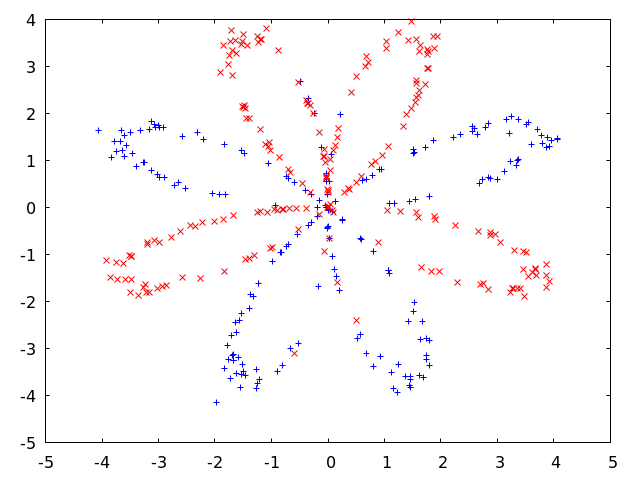

In [12]:
let mut fg = gnuplot::Figure::new();
let xt = x.t().to_owned();
let yt = y.t().to_owned();

let x_x_blue = filter_by(xt.index_axis(Axis(0), 0), yt.index_axis(Axis(0), 0), 1);
let x_y_blue = filter_by(xt.index_axis(Axis(0), 1), yt.index_axis(Axis(0), 0), 1);
let x_x_red = filter_by(xt.index_axis(Axis(0), 0), yt.index_axis(Axis(0), 0), 0);
let x_y_red = filter_by(xt.index_axis(Axis(0), 1), yt.index_axis(Axis(0), 0), 0);

fg.axes2d()
    .points(x_x_blue, x_y_blue, &[gnuplot::PlotOption::Color("blue")])
    .points(x_x_red, x_y_red, &[gnuplot::PlotOption::Color("red")]);
let img = figure_into_image(&mut fg);
img.evcxr_display()

After preprocessing, we will end up with train_x/y and test_x/y.

Each line of your train_x and test_x is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `index` value and re-run to see other images. 

---

c

---

d

e

f

g

---

h

i

j

k

l

m

n

o

p

q

r

s

t

u

v

w

x

y

z

In [13]:
"end of C1W3"

"end of C1W3"